# Simulation of 11-3.9um brightness temperature difference

### Setup

**Libraries used:**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

**Retrieve GFS data:**

In [2]:
date_str = "20240614"

In [3]:
gfs_file = 'model_data/gfs_'+date_str
gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/Users/jturner/miniconda3/envs/FLC/lib/python3.10/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/jturner/miniconda3/envs/FLC/lib/python3.10/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,


**Select region for simulation:**

In [4]:
#--- Georges Bank
latitude_north = 41
latitude_south = 40.8
longitude_west = -68.2
longitude_east = -68

#--- Oaxaca
# latitude_north = 24
# latitude_south = 8
# longitude_west = -109
# longitude_east = -81

region = gfs_ds.sel(latitude=slice(latitude_north, latitude_south), longitude=slice(360+longitude_west, 360+longitude_east))

In [5]:
datetime_str = np.datetime_as_string(region.time.values, unit='h')
datetime_str = datetime_str.replace('T', ' ')+"Z"
print(datetime_str)

2024-06-14 06Z


In [6]:
region

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 1, longitude: 1)
Coordinates:
    time           datetime64[ns] 2024-06-14T06:00:00
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 41.0
  * longitude      (longitude) float64 292.0
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-07-22T11:41 GRIB to CDM+CF via cfgrib-0.9.1...

### Generate optical thickness tables

**Calculate the water vapor mass density for the region:**
* this is described in RadTran Miller presentation notes
* $r_g$ is the mixing ratio of water vapor, averaged between the layers ($p_1$ and $p_2$)
* mass density ($u$) is in kg m-2

$$
u(p_1, p_2) = \frac{1}{g}\int_{p_2}^{p_1} r_g dp
$$

In [7]:
g = 9.807 #m s-2
u = []

for i in range(len(region.isobaricInhPa.values)-1):
    p1 = region.isobaricInhPa.values[i]*100 #kg s-2 m-1
    p2 = region.isobaricInhPa.values[i+1]*100 #kg s-2 m-1
    dp = p1-p2

    r_g = (region.q.values[i] + region.q.values[i+1]) / 2 #kg kg-1

    u.append(((1/g)*r_g*dp)) #kg m-2
    #--- Improved this line, add these changes to FLCI.ipynb

#--- u has dimensions of (hPa, lat, lon)


**Create an optical mass table:**
* The data is 3-dimensional (pressure, latitude, longitude), so the pandas dataframe is no longer the best method
* Instead, we build an x-array to store the optical mass values

In [8]:
optical_mass_da = xr.DataArray(u, dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})
temperature_da = xr.DataArray(region.t[0:-1], dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})


optical_mass_ds = xr.Dataset({'u': optical_mass_da,
                              'T': temperature_da})

**Open the mass extinction look-up tables:**
* made in water_vapor_abs.ipynb

In [9]:
mass_ext_df_13 = pd.read_pickle('tables/mass_ext_band13')
mass_ext_df_14 = pd.read_pickle('tables/mass_ext_band14')
mass_ext_df_07 = pd.read_pickle('tables/mass_ext_band07')

In [10]:
mass_ext_df_13

,1013.171226,962.512665,911.854103,861.195542,810.536981,759.878419,709.219858,658.561297,607.902736,557.244174,506.585613,455.927052,405.268490,354.609929,303.951368,253.292806,202.634245,151.975684,101.317123,50.658561
175,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090
180,0.000112,0.000112,0.000112,0.000112,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000114,0.000114,0.000114,0.000114,0.000114,0.000114,0.000114
185,0.000140,0.000141,0.000141,0.000141,0.000141,0.000141,0.000141,0.000141,0.000141,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142
190,0.000174,0.000174,0.000174,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176
195,0.000214,0.000214,0.000214,0.000215,0.000215,0.000215,0.000215,0.000215,0.000216,0.000216,0.000216,0.000216,0.000216,0.000216,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217
200,0.000261,0.000261,0.000261,0.000262,0.000262,0.000262,0.000262,0.000262,0.000263,0.000263,0.000263,0.000263,0.000263,0.000264,0.000264,0.000264,0.000264,0.000264,0.000264,0.000264
205,0.000315,0.000316,0.000316,0.000316,0.000317,0.000317,0.000317,0.000317,0.000318,0.000318,0.000318,0.000318,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319
210,0.000379,0.000379,0.000379,0.000380,0.000380,0.000380,0.000381,0.000381,0.000381,0.000382,0.000382,0.000382,0.000382,0.000383,0.000383,0.000383,0.000383,0.000383,0.000383,0.000383
215,0.000451,0.000452,0.000452,0.000453,0.000453,0.000453,0.000454,0.000454,0.000455,0.000455,0.000455,0.000456,0.000456,0.000456,0.000456,0.000457,0.000457,0.000457,0.000457,0.000457
220,0.000535,0.000535,0.000536,0.000536,0.000537,0.000537,0.000538,0.000538,0.000538,0.000539,0.000539,0.000540,0.000540,0.000540,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541


**Create the optical thickness table (optical mass * mass extinction):**
* using the mass extinction look-up tables (HITRAN-driven)
* using the optical mass table (GFS-driven)

In [11]:
pressure_profile = optical_mass_ds.hPa[:21].values

optical_thickness_07 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])
optical_thickness_13 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])
optical_thickness_14 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])

print(np.shape(optical_thickness_07))

for z in range(len(pressure_profile)):
    for y in range(len(optical_mass_ds.lat)):
        for x in range(len(optical_mass_ds.lon)):
            
            #--- Getting the T and u from the optical mass dataset
            temperature_value = optical_mass_ds.isel(hPa=z, lat=y, lon=x)['T'].values
            optical_mass_value = optical_mass_ds.isel(hPa=z, lat=y, lon=x)['u'].values

            #---Find the nearest temperature and pressure indices
            nearest_temperature_07 = mass_ext_df_07.index[((mass_ext_df_07.index.values - temperature_value)**2).argmin()]
            nearest_pressure_07 = mass_ext_df_07.columns[((mass_ext_df_07.columns.values - pressure_profile[z])**2).argmin()]

            #---Query the lookup table with the nearest indices
            mass_ext_value_07 = mass_ext_df_07.loc[nearest_temperature_07, nearest_pressure_07]

            optical_thickness_07[z,y,x] = optical_mass_value*mass_ext_value_07

            #---Repeat for the other bands
            nearest_temperature_13 = mass_ext_df_13.index[((mass_ext_df_13.index.values - temperature_value)**2).argmin()]
            nearest_pressure_13 = mass_ext_df_13.columns[((mass_ext_df_13.columns.values - pressure_profile[z])**2).argmin()]
            mass_ext_value_13 = mass_ext_df_13.loc[nearest_temperature_13, nearest_pressure_07]
            optical_thickness_13[z,y,x] = optical_mass_value*mass_ext_value_13

            nearest_temperature_14 = mass_ext_df_14.index[((mass_ext_df_14.index.values - temperature_value)**2).argmin()]
            nearest_pressure_14 = mass_ext_df_14.columns[((mass_ext_df_14.columns.values - pressure_profile[z])**2).argmin()]
            mass_ext_value_14 = mass_ext_df_14.loc[nearest_temperature_14, nearest_pressure_07]
            optical_thickness_14[z,y,x] = optical_mass_value*mass_ext_value_14



(21, 1, 1)


In [28]:
tau_07 = []
for i in optical_thickness_07:
    tau_07.append(i[0][0])

tau_07

[5.434138800806587e-05,
 4.813639140930657e-05,
 4.454408222544199e-05,
 4.105122698975131e-05,
 6.275675496250349e-05,
 3.0007047056872375e-05,
 1.8585265636047412e-05,
 1.3770656664779634e-05,
 5.82705661360133e-06,
 4.681707872078847e-06,
 4.701871830179419e-06,
 5.094237960472664e-06,
 7.0245890285179234e-06,
 5.0405084762532435e-06,
 2.398424009218247e-06,
 1.0489490676140924e-06,
 3.1035721274847667e-07,
 1.1344828904950386e-07,
 1.9711723981882444e-08,
 4.747185677445144e-09,
 1.6782352189128098e-09]

### Build functions for radiance and brightness temperature

**Build the functions for expected radiance and brightness temperature:**
* functions are similar to those in expected_radiance.ipynb, but for a 3d field

**Calculating the blackbody radiance ($B_\lambda^\uparrow$):**

$$
B_\lambda (T) = \frac{2hc^2}{\lambda^5 [e^{hc/k\lambda T} -1]}
$$

* $h$ is the Planck constant, $6.626 \times 10^{-34} \text{ J s}$
* $c$ is the speed of light, $3 \times 10^{8} \text{ m s}^{-1}$
* $k$ is the Boltzmann constant, $1.380 \times 10^{-23} \text{ J K}^{-1}$

In [13]:
def blackbody_radiance(T, wl):
    h = 6.626e-34
    c = 3e8
    k = 1.380e-23
    B = (2*h*c**2)/(wl**5 * (np.exp((h*c)/(k*wl*T))-1))
    return B

**Calculating expected radiance ($I_\lambda$):**

$$
I_\lambda^\uparrow (\infty, \mu)= B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu} + \sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

* $B_\lambda^\uparrow (T_\text{sfc})$ is the blackbody radiance from the surface temperature
* $\tau^*$ is optical thickness of atmosphere
* $\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)$ is transmittance upward from height level ($z_i$) to TOA ($\infty$) with viewing angle ($\mu$)

**Calculating radiance from surface:**

Equation for expected radiance ($I_\lambda^\uparrow$) from the surface through the TOA. Includes the total absorption by the optical thickness, but not the individual absorption/emission of each layer. 

$$
B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu}
$$

In [14]:
def I_sfc(T_sfc, optical_thickness, wl):

    #--- viewing angle of the satellite
    mu = 1

    #--- numpy 3D array sum over the pressure axis
    tau_star = np.sum(optical_thickness, axis=0)
    
    #--- expected radiance calculation
    I_sfc = blackbody_radiance(T_sfc, wl)*np.exp(-tau_star/mu)

    return I_sfc

**Calculating radiance from atmosphere:**

Equation for the expected radiance ($I_\lambda^\uparrow$) from the absorption/emission of each atmospheric layer. 

$$
\sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

In [110]:
def I_atm(optical_thickness, optical_mass_ds, wl):

    #--- Number of pressure levels for integration
    p_len = np.shape(optical_thickness)[0] - 1

    I_levels = []
    mu = 1

    for i in range(p_len):

        #---Temperature and blackbody radiance at current level
        T = optical_mass_ds.isel(hPa=i)['T']
        B = blackbody_radiance(T, wl)
        print("Blackbody radiance from layer (", optical_mass_ds.isel(hPa=i).hPa.values, " hPa) =", B.values)

        tau_above = np.sum(optical_thickness[i+1:], axis=0)
        tau_level = np.sum(optical_thickness[i:], axis=0)

        press_levels = optical_mass_ds['hPa'][:21].values
        dp = press_levels[i+1] - press_levels[i]
        print("Change in pressure = ", dp)
        
        dT = (np.exp(-tau_above/mu)) - (np.exp(-tau_level/mu))
        print("Change in transmittance =", dT)
        
        #---Radiance from each atmospheric level
        I_level = B*dT
        I_levels.append(I_level)

    #---Summing the radiance to get the total at TOA
    I_atm = np.sum(I_levels, axis=0)
    return I_atm

**Calculating the brightness temperature:**

Calculating the brightness temperature ($T_{b,\lambda}$) from the expected radiance: 

$$
T_{b,\lambda} = \frac{hc}{k\lambda \text{ ln}\left[1+\frac{2hc^2}{I \lambda^5}\right]}
$$

In [17]:
def brightness_temperature(I, wl):
    h = 6.626e-34
    c = 2.998e8
    k = 1.380e-23
    Tb = (h*c)/(k*wl * np.log(1 + ((2*h*c**2)/(I*wl**5))))
    return Tb

### Run brightness temperature for specific wavelength (set here)

**Setting wavelength of interest:**

In [18]:
wl = 3.9e-6
optical_thickness = optical_thickness_07
wl_str = str(wl*1e6).replace(".", "_")

**Brightness temperature using NOAA SST as surface:**

In [19]:
sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

In [20]:
#--- Fill the nan values with zero
sst_ds = sst_ds.sst.fillna(0)

Crop SST data down to the same range as the model data: 
* The latitude slice also flips the dataset, so that the north/south orientation is correct

In [21]:
sst_ds = sst_ds.sel(lat=slice(latitude_north,latitude_south,-1), lon=slice(longitude_west+360,longitude_east+360))

Match the SST shape to the GFS shape:

In [22]:
print("Shape of SST array:", np.shape(sst_ds))
print("Shape of optical thickness array:", np.shape(optical_thickness))

#--- This copies two edges out by one more row, to fit the dimensions of the model data
#------ Not necessary for 1D column
# sst_padded = np.pad(sst_ds, ((0, 1), (0, 1)), mode='edge')
# print("Shape of SST padded array:", np.shape(sst_padded))

Shape of SST array: (1, 1)
Shape of optical thickness array: (21, 1, 1)


### Calculate the brightness temperature difference

**Calculating the brightness temperature difference:**

In [23]:
first_wl = 11.2e-6
first_optical_thickness = optical_thickness_14
first_wl_str = str(first_wl*1e6).replace(".", "_")

second_wl = 3.9e-6
second_optical_thickness = optical_thickness_07
second_wl_str = str(second_wl*1e6).replace(".", "_")

In [109]:
first_I_tot = I_sfc(sst_ds.values, first_optical_thickness, first_wl) + I_atm(first_optical_thickness, optical_mass_ds, first_wl)
second_I_tot = I_sfc(sst_ds.values, second_optical_thickness, second_wl) + I_atm(second_optical_thickness, optical_mass_ds, second_wl)

print("brightness temperature of ", first_wl_str, ": ", brightness_temperature(first_I_tot, first_wl))
print("brightness temperature of ", second_wl_str, ": ", brightness_temperature(second_I_tot, second_wl))

BTD = brightness_temperature(first_I_tot, first_wl) - brightness_temperature(second_I_tot, second_wl)
print("BTD: ", BTD)

Blackbody radiance from layer ( 1000.0  hPa) = [[8291430.]]
Change in pressure =  -25.0
Transmittance = [[0.91605906]]
Change in transmittance = [[0.01239459]]
Blackbody radiance from layer ( 975.0  hPa) = [[8250794.5]]
Change in pressure =  -25.0
Transmittance = [[0.92845366]]
Change in transmittance = [[0.01112005]]
Blackbody radiance from layer ( 950.0  hPa) = [[8170776.]]
Change in pressure =  -25.0
Transmittance = [[0.93957371]]
Change in transmittance = [[0.0104088]]
Blackbody radiance from layer ( 925.0  hPa) = [[8040211.5]]
Change in pressure =  -25.0
Transmittance = [[0.94998251]]
Change in transmittance = [[0.00969507]]
Blackbody radiance from layer ( 900.0  hPa) = [[7886437.]]
Change in pressure =  -50.0
Transmittance = [[0.95967757]]
Change in transmittance = [[0.01501285]]
Blackbody radiance from layer ( 850.0  hPa) = [[7620477.5]]
Change in pressure =  -50.0
Transmittance = [[0.97469043]]
Change in transmittance = [[0.00741789]]
Blackbody radiance from layer ( 800.0  hPa)

### Weighting function

In [112]:
#--- Number of pressure levels for integration
p_len = np.shape(optical_thickness_07)[0] - 1

dT_levels_07 = []
dT_levels_14 = []
mu = 1

for i in range(p_len):

    #---Temperature and blackbody radiance at current level
    T = optical_mass_ds.isel(hPa=i)['T']
    B = blackbody_radiance(T, wl)
    print("Blackbody radiance from layer (", optical_mass_ds.isel(hPa=i).hPa.values, " hPa) =", B.values)

    tau_above = np.sum(optical_thickness_07[i+1:], axis=0)
    tau_level = np.sum(optical_thickness_07[i:], axis=0)

    press_levels = optical_mass_ds['hPa'][:21].values
    dp = press_levels[i+1] - press_levels[i]
    print("Change in pressure = ", dp)

    dT = (np.exp(-tau_above/mu)) - (np.exp(-tau_level/mu))    
    dT_levels_07.append(dT[0][0])

for i in range(p_len):

    #---Temperature and blackbody radiance at current level
    T = optical_mass_ds.isel(hPa=i)['T']
    B = blackbody_radiance(T, wl)
    print("Blackbody radiance from layer (", optical_mass_ds.isel(hPa=i).hPa.values, " hPa) =", B.values)

    tau_above = np.sum(optical_thickness_14[i+1:], axis=0)
    tau_level = np.sum(optical_thickness_14[i:], axis=0)

    press_levels = optical_mass_ds['hPa'][:21].values
    dp = press_levels[i+1] - press_levels[i]
    print("Change in pressure = ", dp)

    dT = (np.exp(-tau_above/mu)) - (np.exp(-tau_level/mu))    
    dT_levels_14.append(dT[0][0])


Blackbody radiance from layer ( 1000.0  hPa) = [[412766.94]]
Change in pressure =  -25.0
Blackbody radiance from layer ( 975.0  hPa) = [[407053.3]]
Change in pressure =  -25.0
Blackbody radiance from layer ( 950.0  hPa) = [[395951.34]]
Change in pressure =  -25.0
Blackbody radiance from layer ( 925.0  hPa) = [[378258.84]]
Change in pressure =  -25.0
Blackbody radiance from layer ( 900.0  hPa) = [[358083.8]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 850.0  hPa) = [[324850.25]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 800.0  hPa) = [[303522.25]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 750.0  hPa) = [[281744.97]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 700.0  hPa) = [[263922.47]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 650.0  hPa) = [[224031.4]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 600.0  hPa) = [[181478.7]]
Change in pressure =  -50.0
Blackbody radiance from layer ( 550

/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_34397/3483440637.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(minor='off',labels=yticklabels)


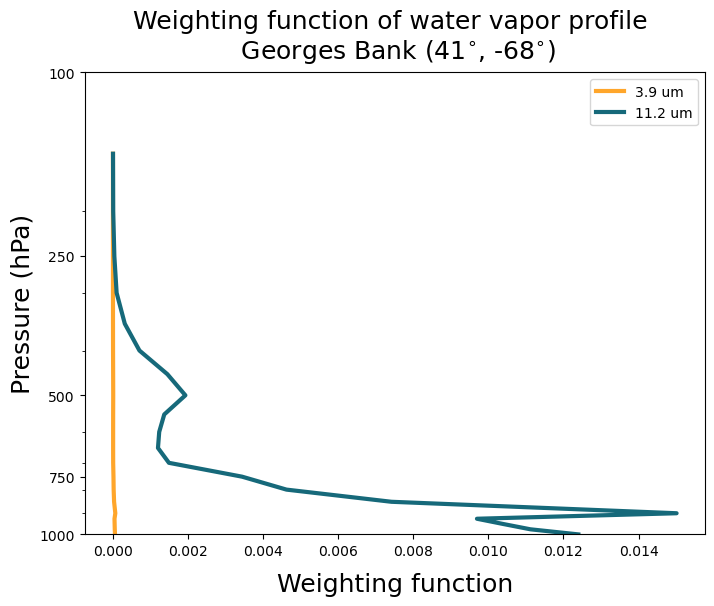

In [106]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(dT_levels_07, press_levels[:20], c='#FFA62B', linewidth=3, label="3.9 um")
ax.plot(dT_levels_14, press_levels[:20], c='#16697A', linewidth=3, label="11.2 um")

ax.legend()

ax.set_title('Weighting function of water vapor profile \n Georges Bank (41$^{\circ}$, -68$^{\circ}$)', size=18, pad=10)
ax.set_xlabel('Weighting function', size=18, labelpad=10)
ax.set_ylabel('Pressure (hPa)', size=18)

#---Y-labels took some wrangling
plt.yscale('log')
ax.set_ylim([1000,100])
ax.set_yticks([1000,750,500,250,100])
yticklabels = ['1000','750','500','250','100']
ax.set_yticklabels(yticklabels)
plt.gca().set_yticklabels(minor='off',labels=yticklabels)

plt.show()